In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-lh" / "data.nc")
ERA5_LH = ERA5["slhf"].sel(valid_time="2024-04-02T12:00:00")
ERA5_LSM = ERA5["lsm"].sel(valid_time="2024-04-02T12:00:00")

In [4]:
import copy


def plot_data(
    da: xr.DataArray,
    title_prefix="",
    title_postfix="",
    error=False,
    n_levels=256,
    cmap=None,
    divergence_point=None,
    levels=None,
    chart=None,
    **kwargs,
):
    UNITS = dict(t2m="degC")
    DIVERGENCE_POINT = dict(t2m=0.0)

    units = None if error else UNITS.get(da.name, None)
    divergence_point = (
        divergence_point
        if divergence_point is not None
        else 0.0
        if error
        else DIVERGENCE_POINT.get(da.name, None)
    )

    source = earthkit.plots.sources.XarraySource(da)

    # compute the default style that earthkit.maps would apply
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=units or source.units,
        )
    )

    da_units = style.convert_units(da.values, source.units)

    # modify the style levels to get a smoother colourbar
    style._levels = earthkit.plots.styles.levels.Levels(
        levels
        if levels is not None
        else earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=n_levels,
        )
    )
    style._legend_kwargs["ticks"] = earthkit.plots.styles.levels.auto_range(
        da_units,
        divergence_point=divergence_point,
        n_levels=10,
    )

    style._kwargs.update(kwargs)

    # force the colourmap to coolwarm for error plots
    style._colors = cmap if cmap is not None else "coolwarm" if error else style._colors

    show = chart is None
    if chart is None:
        chart = earthkit.plots.Map()

    # quickplot with the modified style
    chart.quickplot(
        da,
        units=units,
        style=style,
    )

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    chart.title(
        f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
    )

    if show:
        chart.show()

In [5]:
from numcodecs_safeguards.lossless import _default_lossless_for_safeguards

from compression_safeguards import Safeguards
from compression_safeguards.utils.bindings import Bindings

In [6]:
prediction = np.zeros_like(ERA5_LH.values)

In [7]:
lossless = _default_lossless_for_safeguards()

In [8]:
eb_low = dict(kind="eb", type="abs", eb=1e2)
eb_high = dict(kind="eb", type="abs", eb=1e4)

In [9]:
sg_low = Safeguards(safeguards=[eb_low])

correction_sg_low = sg_low.compute_correction(ERA5_LH.values, prediction)
encoded_sg_low = np.asarray(lossless.encode(correction_sg_low))

ERA5_LH_sg_low = ERA5_LH.copy(
    data=sg_low.apply_correction(prediction, correction_sg_low)
)

In [10]:
sg_high = Safeguards(safeguards=[eb_high])

correction_sg_high = sg_high.compute_correction(ERA5_LH.values, prediction)
encoded_sg_high = np.asarray(lossless.encode(correction_sg_high))

ERA5_LH_sg_high = ERA5_LH.copy(
    data=sg_high.apply_correction(prediction, correction_sg_high)
)

In [11]:
sg_roi = Safeguards(
    safeguards=[
        dict(
            kind="select",
            selector="lsm",
            safeguards=[
                # 0: absolute error for <90% land (sea)
                eb_high,
                # 1: absolute error for >=90% land (land)
                eb_low,
            ],
        ),
    ]
)

correction_sg_roi = sg_roi.compute_correction(
    ERA5_LH.values,
    prediction,
    late_bound=Bindings(
        # lsm: 1 for >=90% land, 0 otherwise
        lsm=(ERA5_LSM >= 0.9).values,
    ),
)
encoded_sg_roi = np.asarray(lossless.encode(correction_sg_roi))

ERA5_LH_sg_roi = ERA5_LH.copy(
    data=sg_roi.apply_correction(prediction, correction_sg_roi)
)

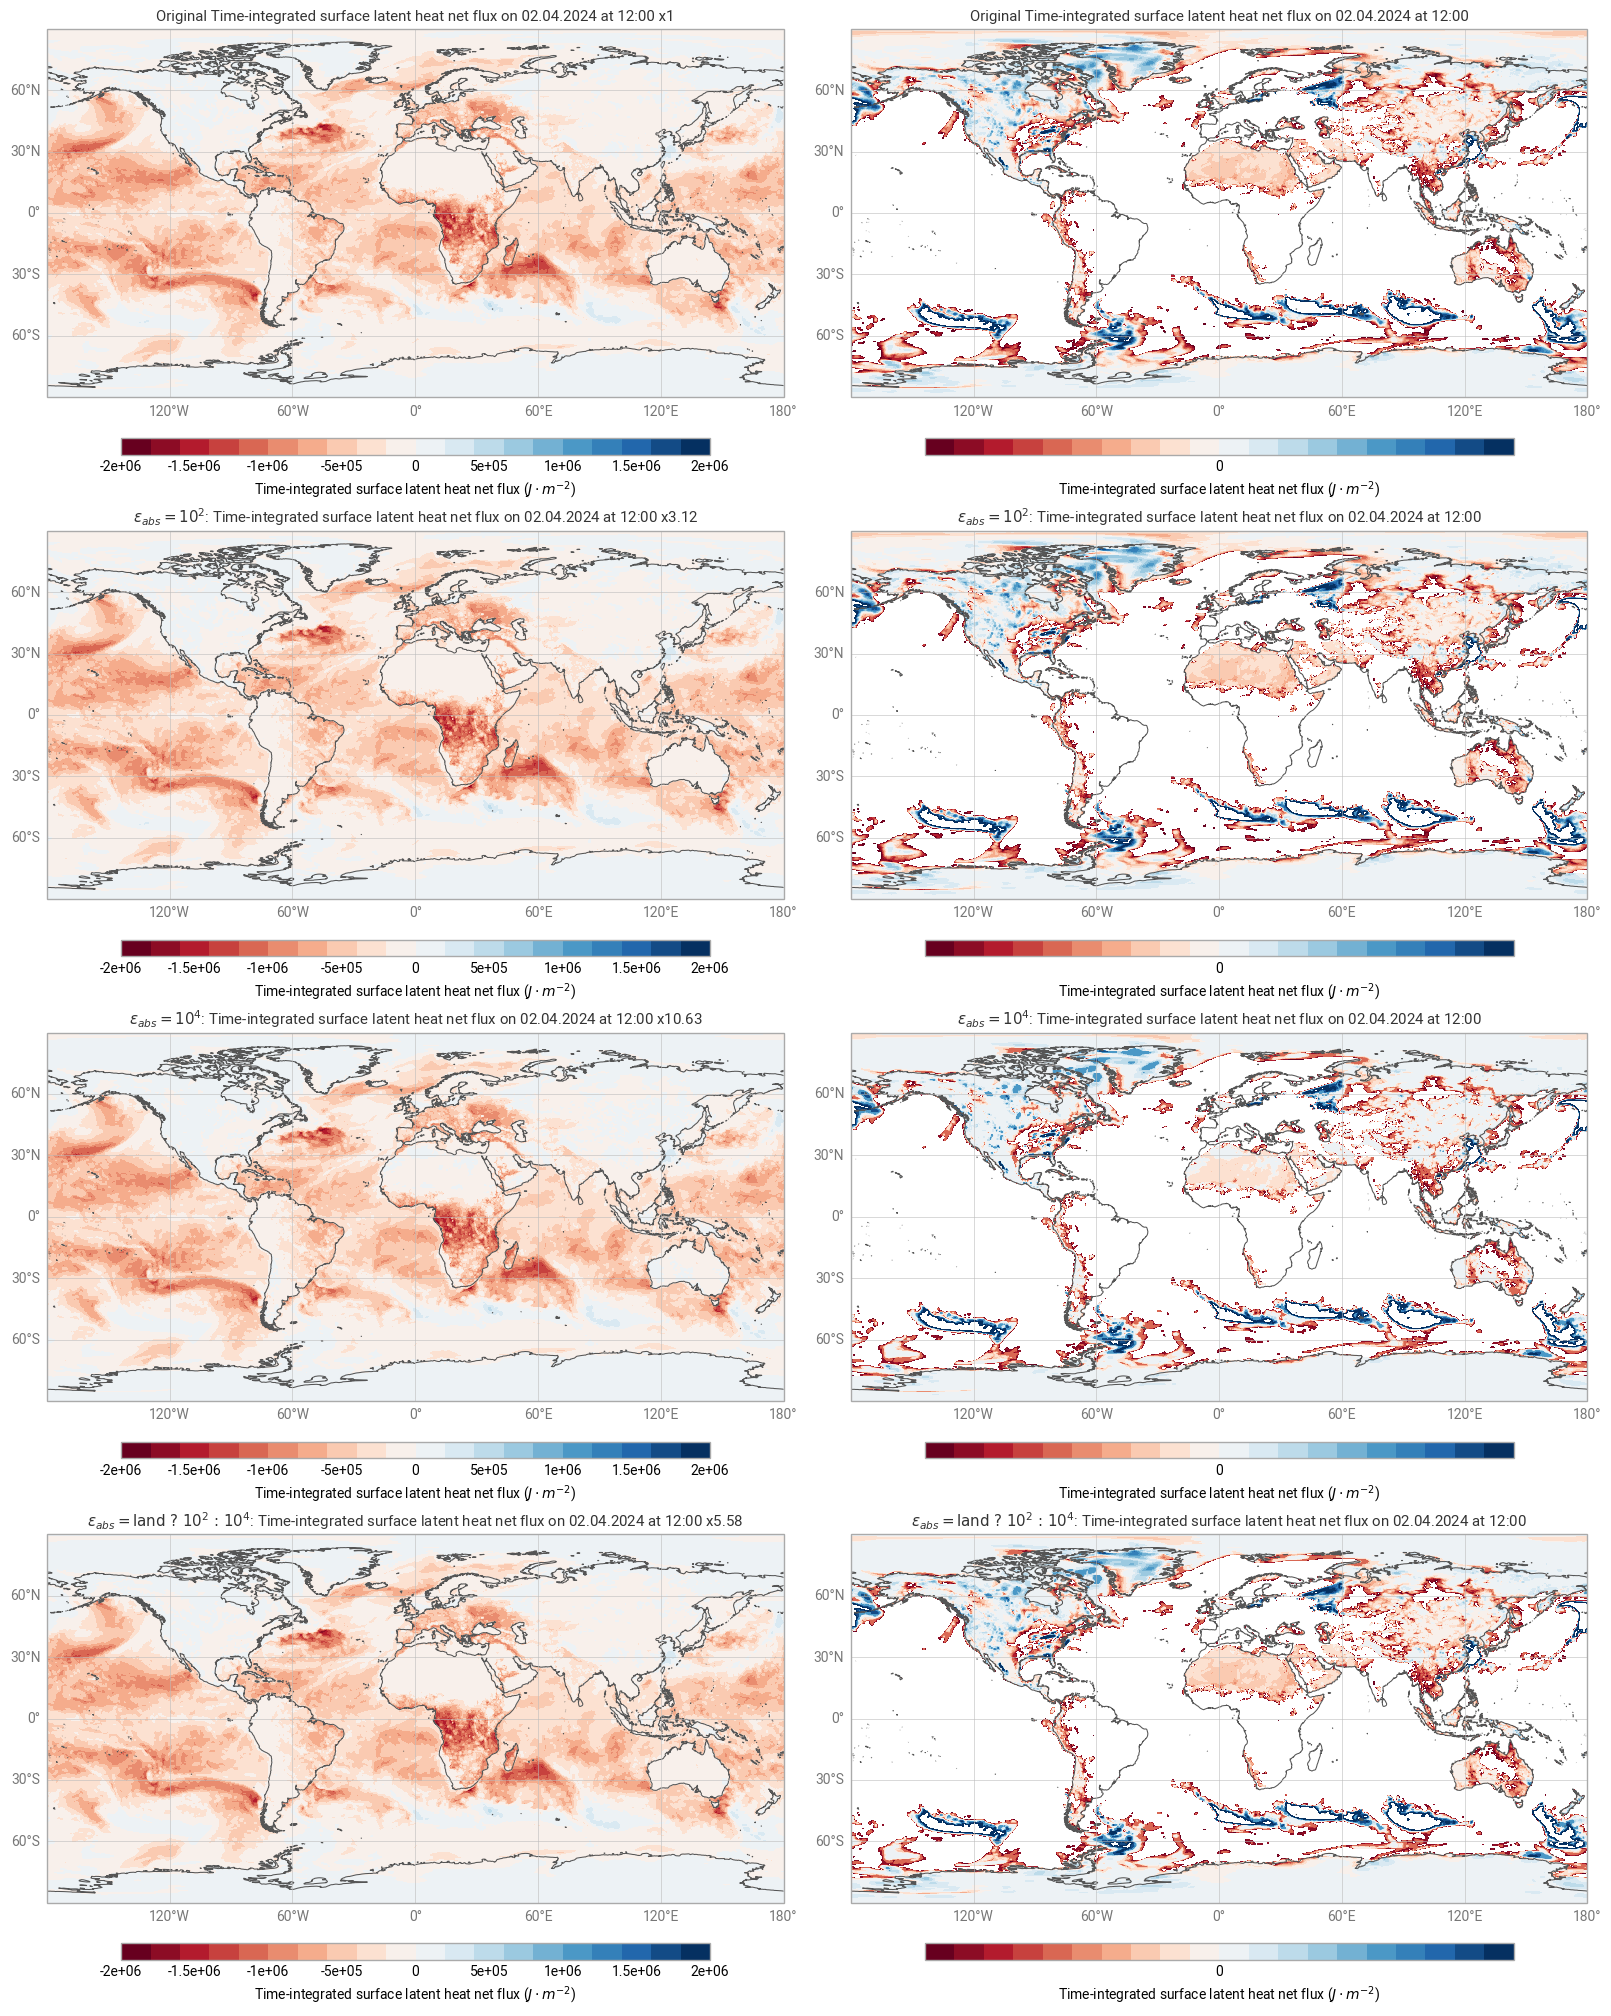

In [12]:
fig = earthkit.plots.Figure(rows=4, columns=2, size=(16, 20))

plot_data(
    ERA5_LH,
    title_prefix="Original ",
    title_postfix=" x1",
    levels=np.arange(-2, 2.01, 0.2) * 1e6,
    cmap="RdBu",
    divergence_point=0,
    chart=fig.add_map(row=0, column=0),
)
plot_data(
    ERA5_LH,
    title_prefix="Original ",
    levels=np.arange(-6, 6.01, 0.6) * 1e4,
    cmap="RdBu",
    divergence_point=0,
    extend="neither",
    chart=fig.add_map(row=0, column=1),
)

plot_data(
    ERA5_LH_sg_low,
    title_prefix=r"$\epsilon_{{abs}} = 10^{{2}}$: ",
    title_postfix=f" x{np.round(ERA5_LH.nbytes / encoded_sg_low.nbytes, 2)}",
    levels=np.arange(-2, 2.01, 0.2) * 1e6,
    cmap="RdBu",
    divergence_point=0,
    chart=fig.add_map(row=1, column=0),
)
plot_data(
    ERA5_LH_sg_low,
    title_prefix=r"$\epsilon_{{abs}} = 10^{{2}}$: ",
    levels=np.arange(-6, 6.01, 0.6) * 1e4,
    cmap="RdBu",
    divergence_point=0,
    extend="neither",
    chart=fig.add_map(row=1, column=1),
)

plot_data(
    ERA5_LH_sg_high,
    title_prefix=r"$\epsilon_{{abs}} = 10^{{4}}$: ",
    title_postfix=f" x{np.round(ERA5_LH.nbytes / encoded_sg_high.nbytes, 2)}",
    levels=np.arange(-2, 2.01, 0.2) * 1e6,
    cmap="RdBu",
    divergence_point=0,
    chart=fig.add_map(row=2, column=0),
)
plot_data(
    ERA5_LH_sg_high,
    title_prefix=r"$\epsilon_{{abs}} = 10^{{4}}$: ",
    levels=np.arange(-6, 6.01, 0.6) * 1e4,
    cmap="RdBu",
    divergence_point=0,
    extend="neither",
    chart=fig.add_map(row=2, column=1),
)

plot_data(
    ERA5_LH_sg_roi,
    title_prefix=r"$\epsilon_{{abs}} = \text{{land ? }}10^{{2}}\text{{ : }}10^{{4}}$: ",
    title_postfix=f" x{np.round(ERA5_LH.nbytes / encoded_sg_roi.nbytes, 2)}",
    levels=np.arange(-2, 2.01, 0.2) * 1e6,
    cmap="RdBu",
    divergence_point=0,
    chart=fig.add_map(row=3, column=0),
)
plot_data(
    ERA5_LH_sg_roi,
    title_prefix=r"$\epsilon_{{abs}} = \text{{land ? }}10^{{2}}\text{{ : }}10^{{4}}$: ",
    levels=np.arange(-6, 6.01, 0.6) * 1e4,
    cmap="RdBu",
    divergence_point=0,
    extend="neither",
    chart=fig.add_map(row=3, column=1),
)